In [1]:
# %%capture -- uncomment this line in Jupyter to suppress pip install output
# !pip install openai playwright pandas Pillow tabulate "ipython[notebook]" pydantic nest_asyncio python-dotenv requests > /dev/null

# %%capture -- uncomment this line in Jupyter to suppress playwright install output
# !playwright install chromium > /dev/null

# --- Imports ---
import asyncio
import json
import os
import nest_asyncio
import pprint
import base64
from io import BytesIO
import pandas as pd
from playwright.async_api import async_playwright
from openai import OpenAI
from PIL import Image
from tabulate import tabulate
import traceback # For detailed error printing

# Ensure IPython display functions are available
try:
    from IPython.display import display, HTML, Markdown, Image as IPImage
    ipython_available = True
except ImportError:
    print("Warning: IPython environment not detected. HTML/Image display will not work.")
    # Define dummy functions if IPython is not available
    def display(obj): print(obj)
    def HTML(data): return str(data)
    def Markdown(data): return str(data)
    def IPImage(data): return None
    ipython_available = False

from pydantic import BaseModel, Field, HttpUrl
from typing import Optional, List
from dotenv import load_dotenv

# --- Load .env file ---
dotenv_loaded = load_dotenv()
if dotenv_loaded:
    print(".env file loaded successfully.")
else:
    print("Warning: .env file not found. Ensure it exists in the notebook's directory or parent directories.")
    print("Make sure the OPENAI_API_KEY environment variable is set manually if .env is not used.")

# --- Apply nest_asyncio ---
nest_asyncio.apply()
print("nest_asyncio applied.")

# --- Helper Function ---
def get_openai_api_key():
    """Retrieves the OpenAI API key from environment variables."""
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        error_message = "OpenAI API key not found. Please ensure it's set in your .env file or environment variables."
        print(f"❌ Critical Error: {error_message}")
        raise ValueError(error_message)
    return api_key

# --- OpenAI Client Initialization ---
try:
    print("Initializing OpenAI client...")
    client = OpenAI(api_key=get_openai_api_key())
    print("OpenAI client initialized successfully.")
except ValueError as e:
    # Error already printed in get_openai_api_key if raised from there
    raise SystemExit("Exiting due to missing API key.")

# --- Web Scraper Agent Class ---
class WebScraperAgent:
    def __init__(self):
        self.playwright = None
        self.browser = None
        self.page = None
        print("WebScraperAgent initialized.")

    async def init_browser(self):
      print("Initializing browser...")
      try:
          self.playwright = await async_playwright().start()
          self.browser = await self.playwright.chromium.launch(
              headless=True,
              args=[
                  "--disable-dev-shm-usage", "--no-sandbox", "--disable-setuid-sandbox",
                  "--disable-accelerated-2d-canvas", "--disable-gpu",
                  # Add other stable args if needed
              ]
          )
          self.page = await self.browser.new_page()
          self.page.set_default_timeout(60000) # 60 seconds default timeout
          print("Browser initialized successfully.")
      except Exception as e:
          print(f"❌ Error initializing browser: {e}")
          await self.close() # Attempt cleanup on init failure
          raise

    async def scrape_content(self, url):
        if not self.page or self.page.is_closed():
            print("Page not found or closed, re-initializing browser...")
            try:
                 await self.init_browser()
            except Exception as e:
                 print(f"❌ Failed to re-initialize browser during scrape: {e}")
                 return None # Cannot proceed if browser init fails here

        print(f"Navigating to {url}...")
        try:
            await self.page.goto(url, wait_until="networkidle")
            print("Page navigation successful (network idle).")
            print("Retrieving page content...")
            content = await self.page.content()
            print(f"Page content retrieved (length: {len(content)}).")
            return content
        except Exception as e:
            print(f"❌ Error during scraping content from {url}: {e}")
            try:
                if self.page and not self.page.is_closed():
                    await self.take_screenshot("error_screenshot.png")
                    print("Saved error screenshot to error_screenshot.png")
            except Exception as se:
                print(f"Could not take error screenshot: {se}")
            return None

    async def take_screenshot(self, path="screenshot.png"):
        if not self.page or self.page.is_closed():
             print("Cannot take screenshot, page is not available.")
             return None
        print(f"Taking full page screenshot: {path}")
        try:
            await self.page.screenshot(path=path, full_page=True)
            print("Screenshot saved.")
            return path
        except Exception as e:
            print(f"❌ Error taking screenshot: {e}")
            return None

    async def screenshot_buffer(self):
        if not self.page or self.page.is_closed():
             print("Cannot take screenshot buffer, page is not available.")
             return None
        print("Taking viewport screenshot buffer...")
        try:
            screenshot_bytes = await self.page.screenshot(type="png", full_page=False)
            print("Screenshot buffer captured.")
            return screenshot_bytes
        except Exception as e:
            print(f"❌ Error taking screenshot buffer: {e}")
            return None

    # --- >>> CORRECTED close method <<< ---
    async def close(self):
        """Safely closes Playwright resources."""
        print("Closing browser and Playwright resources...")
        # Close page first if it exists and is open
        if self.page and not self.page.is_closed():
            try:
                await self.page.close()
            except Exception as e:
                print(f"Note: Error closing page: {e}") # Log non-critical error
        # Close browser if it exists and is connected
        if self.browser and self.browser.is_connected():
             try:
                 await self.browser.close()
             except Exception as e:
                 print(f"Note: Error closing browser: {e}") # Log non-critical error
        # Stop Playwright if the instance exists
        if self.playwright:
            try:
                # Simply attempt to stop it; Playwright handles its internal state.
                await self.playwright.stop()
            except Exception as e:
                 # Catch potential errors during stop
                 print(f"Note: Error stopping Playwright: {e}")
        # Reset instance variables regardless of errors during close
        self.playwright = None
        self.browser = None
        self.page = None
        print("Browser and Playwright resources released.")
    # --- End of CORRECTED close method ---


# --- Pydantic Models for Euron.one Articles ---
class EuronArticle(BaseModel):
    title: str = Field(..., description="The main title of the article")
    articleUrl: Optional[HttpUrl] = Field(None, description="The direct URL to the full article")
    imageUrl: Optional[HttpUrl] = Field(None, description="The URL of the main image associated with the article")
    excerpt: Optional[str] = Field(None, description="A short summary or excerpt of the article")

class EuronArticleList(BaseModel):
    articles: List[EuronArticle] = Field(..., description="A list of articles extracted from the page")

# --- LLM Processing Function ---
async def process_with_llm(html, instructions, truncate = False):
    if not html:
        print("No HTML content received for LLM processing.")
        return None
    print("Sending content to LLM for processing...")
    max_len = 150000 # Max length estimate
    content_to_send = html
    if truncate and len(html) > max_len:
        print(f"HTML content truncated to {max_len} characters for LLM.")
        content_to_send = html[:max_len]

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini", # Recommended mini model
            messages=[{
                "role": "system",
                "content": f"""
                You are an expert web scraping agent. Your task is to analyze HTML and extract information based on instructions, returning *only* a valid JSON object matching the requested schema.

                User Instructions:
                {instructions}

                Target Schema: EuronArticleList
                Fields per article: title (string), articleUrl (URL string or null), imageUrl (URL string or null), excerpt (string or null).
                Ensure URLs are absolute (e.g., start with https://). Base domain is euron.one if needed for relative URLs.

                Return ONLY the valid JSON object. No extra text, explanations, or markdown.
                """
            }, {
                "role": "user",
                "content": content_to_send
            }],
            temperature=0.1,
            response_format={"type": "json_object"},
        )

        response_content = completion.choices[0].message.content
        print("LLM response received.")

        parsed_data = EuronArticleList.model_validate_json(response_content)
        print("LLM response successfully parsed and validated.")
        return parsed_data

    except json.JSONDecodeError as json_err:
        print(f"❌ Error: Failed to decode JSON from LLM response.")
        # Print the raw response if JSON decoding fails
        if 'response_content' in locals(): print(f"Raw response was: {response_content}")
        print(f"JSON Decode Error: {json_err}")
        return None
    except Exception as e: # Catches Pydantic validation errors too
        print(f"❌ Error during LLM processing or validation: {str(e)}")
        if 'response_content' in locals():
            print(f"Raw response causing error (if available): {response_content}")
        return None

# --- Main Web Scraper Function ---
async def webscraper(target_url, instructions):
    result = None
    screenshot_bytes = None
    # Instantiate agent within the function scope
    scraper = WebScraperAgent()

    try:
        await scraper.init_browser() # Handles its own errors and cleanup via its close method
        print(f"\n--- Starting scraping process for: {target_url} ---")
        html_content = await scraper.scrape_content(target_url)

        if html_content:
            print("HTML content extracted successfully.")
            screenshot_bytes = await scraper.screenshot_buffer()
            if screenshot_bytes: print("Screenshot captured successfully.")
            else: print("Failed to capture screenshot.")

            print("Processing content with LLM...")
            result: Optional[EuronArticleList] = await process_with_llm(html_content, instructions, True)

            if result:
                print("\n--- LLM processing completed successfully ---")
                print(f"Extracted {len(result.articles)} articles total by LLM.") # Report total extracted
            else:
                print("\n--- LLM processing failed or returned no data ---")
        else:
            print("\n--- Failed to extract HTML content, stopping process ---")

    except Exception as e:
        print(f"❌ An unexpected error occurred during the web scraping process: {str(e)}")
        traceback.print_exc() # Print detailed traceback in notebook
    finally:
        print("\n--- Triggering scraper resource release ---")
        # Ensure close is always called, even if init_browser failed partially
        if scraper: # Check if scraper object was successfully created
             await scraper.close()

    return result, screenshot_bytes

# --- Main Execution Function (for Notebook) ---
async def main():
    target_url = "https://www.bbc.com/news"
    instructions = f"""
    Extract the main course listings or articles displayed on the homepage '{target_url}'.
    Focus on items that look like distinct entries (courses, news posts, blog entries).
    Provide the title, the full article/course URL (articleUrl), the main image URL (imageUrl), and a short description/excerpt (excerpt) for each.
    """

    print("--- Running Web Scraper ---")
    result, screenshot = await webscraper(target_url, instructions)
    print("\n--- Scraping Finished ---")

    # --- Display Results (Optimized for Jupyter) ---
    if screenshot and ipython_available:
        print("\n--- Screenshot (Viewport) ---")
        try:
            display(IPImage(data=screenshot))
        except Exception as e:
            print(f"Could not display screenshot: {e}")
    elif screenshot:
         print("\n--- Screenshot Captured (but IPython not available for display) ---")
         try:
             with open("euron_screenshot.png", "wb") as f: f.write(screenshot)
             print("Screenshot saved to euron_screenshot.png")
         except Exception as e:
             print(f"Error saving screenshot: {e}")

    # --- Process and Limit Results ---
    if result and result.articles:
        print("\n--- Processing Extracted Articles ---")

        # <<< LIMITING LOGIC >>>
        limit = 5 # Set the desired limit
        original_count = len(result.articles)
        print(f"Limiting display to the first {limit} articles (out of {original_count} extracted by LLM).")
        articles_to_display = result.articles[:limit] # Slice the list

        if not articles_to_display:
             print("No articles available to display after applying limit.")
        else:
            articles_data = [article.model_dump() for article in articles_to_display]
            df = pd.DataFrame(articles_data)

            # --- HTML Table Formatting ---
            def path_to_image_html(url):
                if pd.isna(url) or url is None: return "No Image"
                url_str = str(url)
                if isinstance(url_str, str) and url_str.startswith('http'):
                    return f'<img src="{url_str}" width="100" style="min-height:50px; object-fit: cover;" onerror="this.onerror=null;this.src=\'https://via.placeholder.com/100x50?text=Error\';"> '
                return "Invalid URL"

            def url_to_link_html(url, text=None):
                 if pd.isna(url) or url is None: return "No URL"
                 url_str = str(url)
                 display_text = text if text else url_str
                 if isinstance(url_str, str) and url_str.startswith('http'):
                     return f'<a href="{url_str}" target="_blank">{display_text}</a>'
                 return "Invalid URL"

            # Select and potentially rename columns for display
            columns_to_display = ['title', 'excerpt', 'imageUrl', 'articleUrl']
            if not all(col in df.columns for col in columns_to_display):
                 print(f"Warning: Not all expected columns {columns_to_display} found in DataFrame. Available: {list(df.columns)}")
                 # Attempt to display available columns that match the expected ones
                 available_cols = [col for col in columns_to_display if col in df.columns]
                 df_display = df[available_cols].copy()
            else:
                 df_display = df[columns_to_display].copy()

            # Optional renaming (adjust column names in formatters accordingly)
            rename_map = {'excerpt': 'description', 'articleUrl': 'courseURL', 'imageUrl': 'Image'}
            # Only rename columns that actually exist in df_display
            rename_map_filtered = {k: v for k, v in rename_map.items() if k in df_display.columns}
            df_display.rename(columns=rename_map_filtered, inplace=True)


            # Prepare formatters using the *final* column names in df_display
            formatters = {}
            if 'Image' in df_display.columns: # Check if 'Image' column exists after potential renaming
                formatters['Image'] = path_to_image_html
            elif 'imageUrl' in df_display.columns: # Fallback to original name if not renamed
                 formatters['imageUrl'] = path_to_image_html

            if 'courseURL' in df_display.columns:
                 formatters['courseURL'] = lambda url: url_to_link_html(url, "View Details")
            elif 'articleUrl' in df_display.columns:
                 formatters['articleUrl'] = lambda url: url_to_link_html(url, "View Details")


            if ipython_available:
                try:
                    # Display as HTML table
                    html_table = df_display.to_html(formatters=formatters, escape=False, index=False, border=1, justify='center')
                    print("\n--- Displaying Top 5 Results ---")
                    display(HTML(html_table))

                except Exception as e:
                     print(f"❌ Could not display results as HTML table: {e}")
                     traceback.print_exc() # Show error details
                     print("Falling back to text table:")
                     print(tabulate(df_display, headers='keys', tablefmt='grid', showindex=False))
            else:
                # Fallback for non-IPython environments
                print("\n--- Displaying Top 5 Results (Text Table) ---")
                print(tabulate(df_display, headers='keys', tablefmt='grid', showindex=False))

    elif result and not result.articles:
        print("\n--- No articles extracted by the LLM ---")
    else:
        # This covers case where result itself is None (e.g., scraping failed)
        print("\n--- No results obtained or scraping failed ---")

# --- End of function definitions ---
print("\nScript definitions loaded. To run the scraper, execute 'await main()' in the next cell.")

.env file loaded successfully.
nest_asyncio applied.
Initializing OpenAI client...
OpenAI client initialized successfully.

Script definitions loaded. To run the scraper, execute 'await main()' in the next cell.


--- Running Web Scraper ---
WebScraperAgent initialized.
Initializing browser...
Browser initialized successfully.

--- Starting scraping process for: https://www.bbc.com/news ---
Navigating to https://www.bbc.com/news...
Page navigation successful (network idle).
Retrieving page content...
Page content retrieved (length: 315380).
HTML content extracted successfully.
Taking viewport screenshot buffer...
Screenshot buffer captured.
Screenshot captured successfully.
Processing content with LLM...
Sending content to LLM for processing...
HTML content truncated to 150000 characters for LLM.
LLM response received.
❌ Error during LLM processing or validation: 3 validation errors for EuronArticleList
articles.2.articleUrl
  Input should be a valid URL, relative URL without a base [type=url_parsing, input_value='/news/articles/cly1md6r3l8o', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/url_parsing
articles.3.articleUrl
  Input should be a valid URL, rela

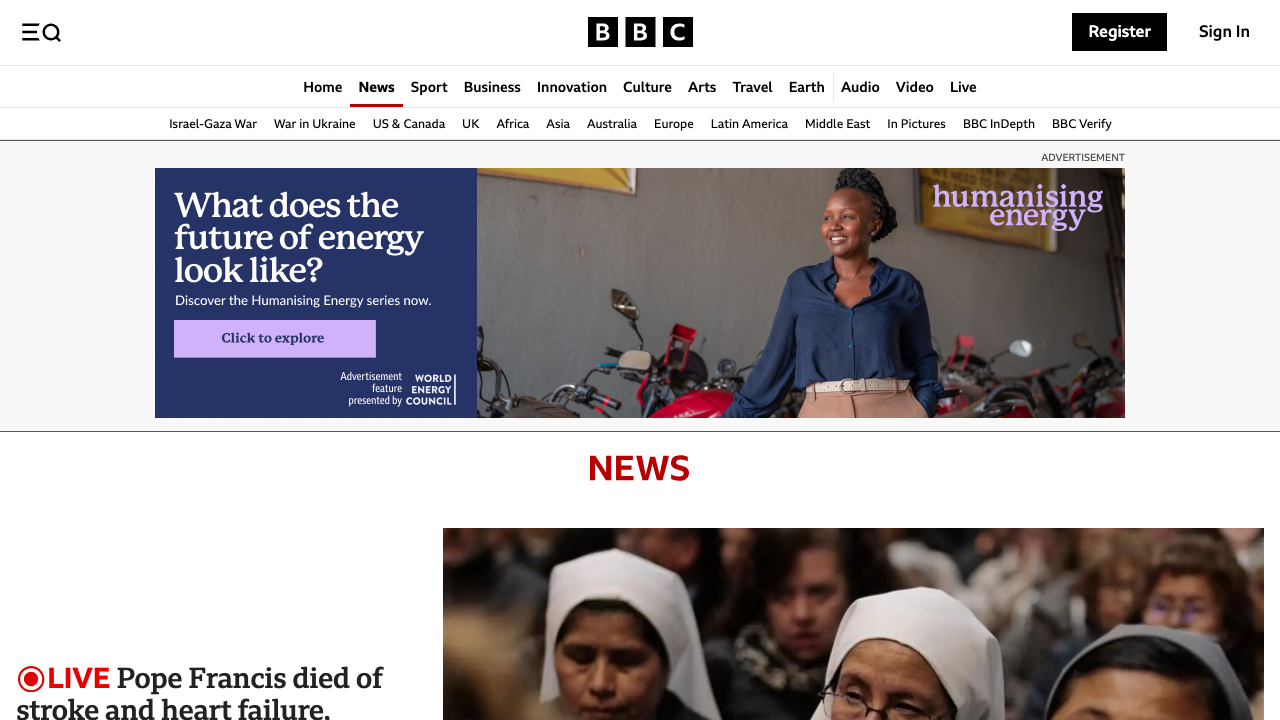


--- No results obtained or scraping failed ---


In [2]:
await main()